In [1]:
from train import WNetAE
import torch

In [2]:
net = WNetAE.load_from_checkpoint(
    "/data2/vqvae-ckpt/run1/last.ckpt",
    dim=32,
    f=16,
    bits=16,
    num_blocks=2,
    mults=[1, 2, 2, 4, 4],
    u_net_stages=1,
    mse_weight=1.0,
    lpips_weight=0.1,
    aux_weight=0.1,
)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/jack/.conda/envs/vqvae/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [3]:
book_modules = net.net.encoder.codebooks
embs = torch.stack([layer._codebook.embed for layer in book_modules.layers]).detach()
embs.shape

torch.Size([16, 2, 16])

In [4]:
from einops import rearrange

In [5]:
flat_embs = rearrange(embs, 'b i d -> (b i) d')
orthogonality = torch.einsum('id,jd->ij', flat_embs, flat_embs)

In [6]:
map = orthogonality * (1 - torch.eye(flat_embs.size(0)))

In [7]:
mags = embs.pow(2).sum(dim=-1).sqrt()

In [8]:
import matplotlib.pyplot as plt

In [9]:
mag_mins = mags[:,0].minimum(mags[:,1])
mag_maxs = mags[:,0].maximum(mags[:,1])

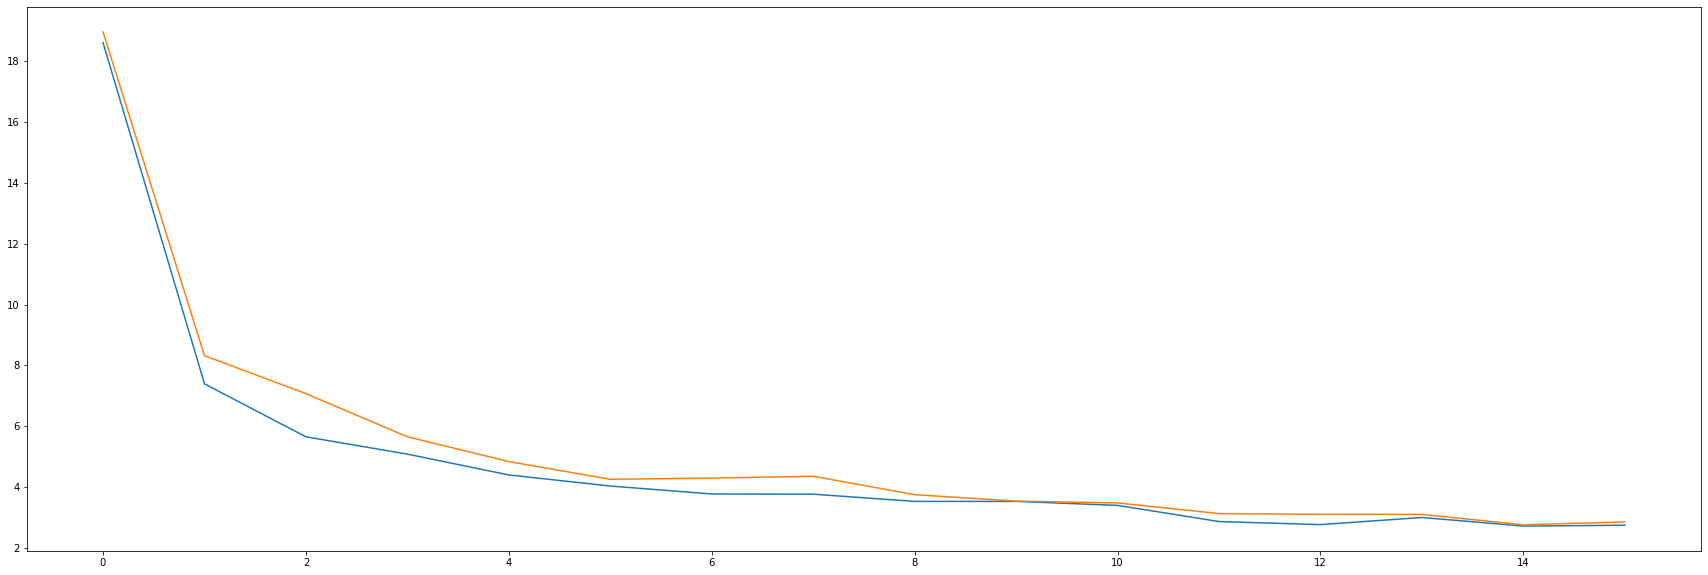

In [10]:
plt.figure(figsize=(30,10))
plt.plot(mag_mins)
plt.plot(mag_maxs)
#plt.yscale('log')

In [11]:
from loader import ImageFolder
from pathlib import Path

ds = ImageFolder(Path('/data1/DALLE-datasets/general/cc12'), 'ixs_filtered.txt', 256, 'images')

In [12]:
import torchvision.transforms.functional as TF

In [13]:
mk_img = lambda t: TF.to_pil_image(t.add(1).div(2).clamp(0, 1))
it = ds[103]
in_img = mk_img(it)
rc_img = mk_img(net.net(ds[103][None])[0][0])

In [14]:
_, ixs, _ = net.net.encoder(it[None])
flipped_ixs = 1 - ixs
bits = torch.arange(0, 16, 1)[None,:,None,None]
flips = torch.arange(0, 16, 1)[:,None,None,None]
ixs_ = torch.where(bits < flips, ixs, flipped_ixs)
ixs_.shape, ixs_.min(), ixs_.max()

(torch.Size([16, 16, 16, 16]), tensor(0), tensor(1))

In [15]:
import torch.nn.functional as F

In [16]:
qs = torch.einsum('bchwi,cid->bdhw',F.one_hot(ixs_).to(dtype=torch.float32), embs)
# qs = torch.einsum('bchwi,cid->bdhw',F.one_hot(ixs).to(dtype=torch.float32), embs)

In [17]:
rc_2_img = net.net.decoder(qs)

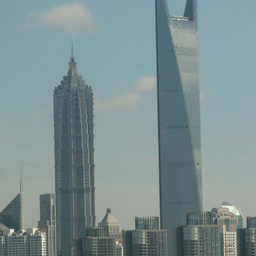

In [18]:
in_img

In [19]:
from torchvision.utils import make_grid

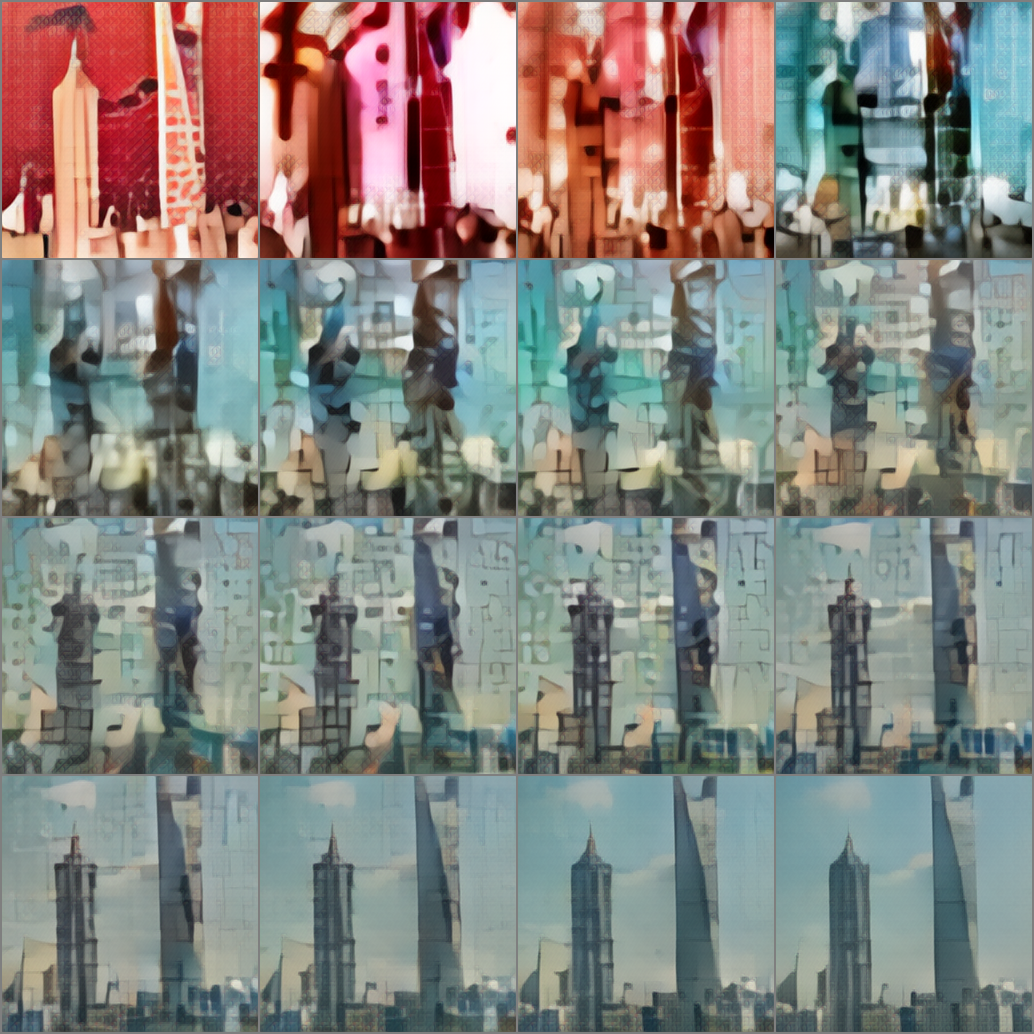

In [20]:
mk_img(make_grid(rc_2_img, nrow=4))

In [21]:
def decode(ixs):
    qs = torch.einsum('bchwi,cid->bdhw',F.one_hot(ixs).to(dtype=torch.float32), embs)
    return net.net.decoder(qs)

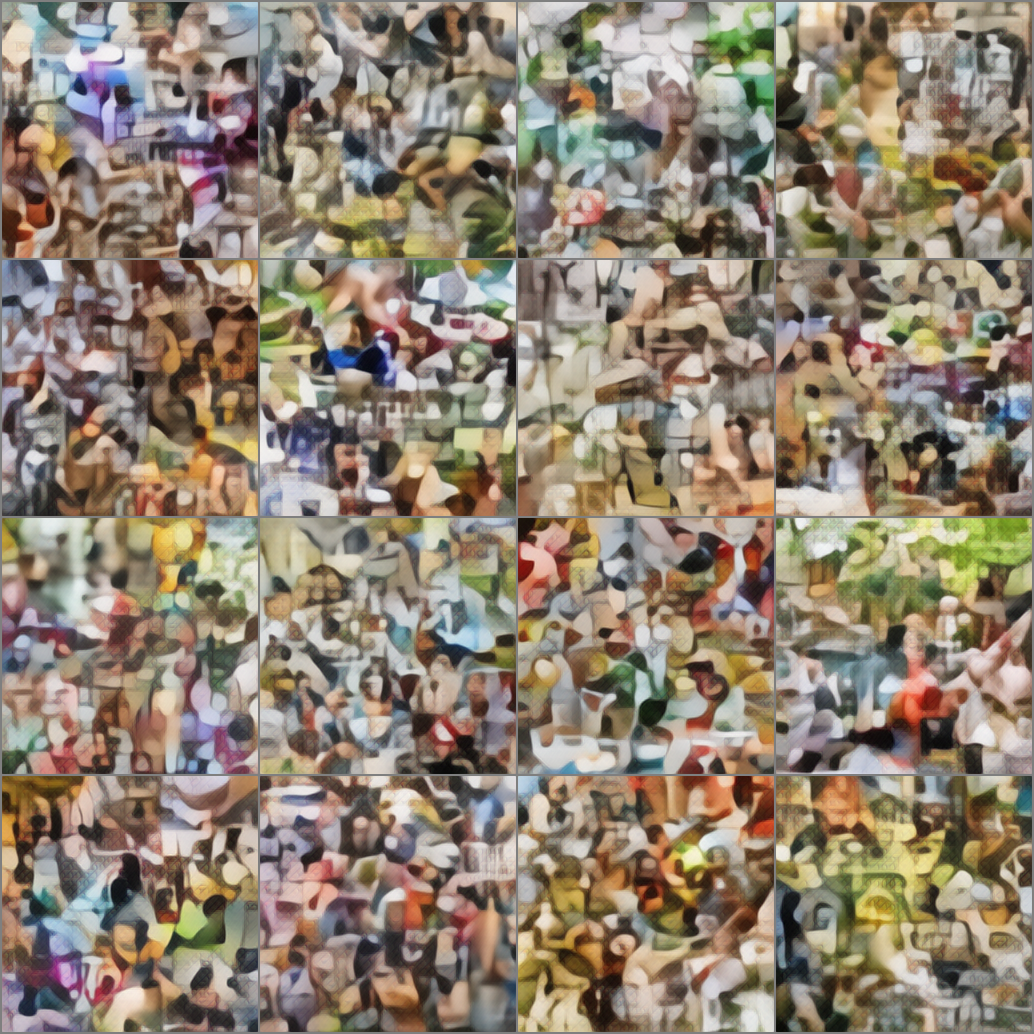

In [31]:
mk_img(make_grid(decode(torch.randint(0, 2, [16, 16, 16, 16])), nrow=4))